In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import json


paths = [
    "experiments/results/chunks_identity_normTrue_n14451_topk1000_20250731_135642/results_chunks_identity_normTrue_n14451_topk1000_20250731_135642.json",
    "experiments/results/chunks_add_prev_3_normTrue_n14451_topk1000_20250731_152719/results_chunks_add_prev_3_normTrue_n14451_topk1000_20250731_152719.json",
    "experiments/results/contributions_identity_normTrue_n14451_topk1000_20250731_155812/results_contributions_identity_normTrue_n14451_topk1000_20250731_155812.json",
    "experiments/results/contributions_add_prev_3_normTrue_n14451_topk1000_20250731_163726/results_contributions_add_prev_3_normTrue_n14451_topk1000_20250731_163726.json",
    "experiments/results/contributions_add_prev_3_normTrue_n14451_topk1000_20250731_181942/results_contributions_add_prev_3_normTrue_n14451_topk1000_20250731_181942.json",
    "experiments/results/basic_chunks_add_bge_instruction_normTrue_cosine_n14681_20250806_102946/results_basic_chunks_add_bge_instruction_normTrue_cosine_n14681_20250806_102946.json",
]

names = ["chunks", "chunks+prev3", "contributions", "contributions+prev3", "chunks+contributions+prev3 (50/50)", "chunks+instruction"]

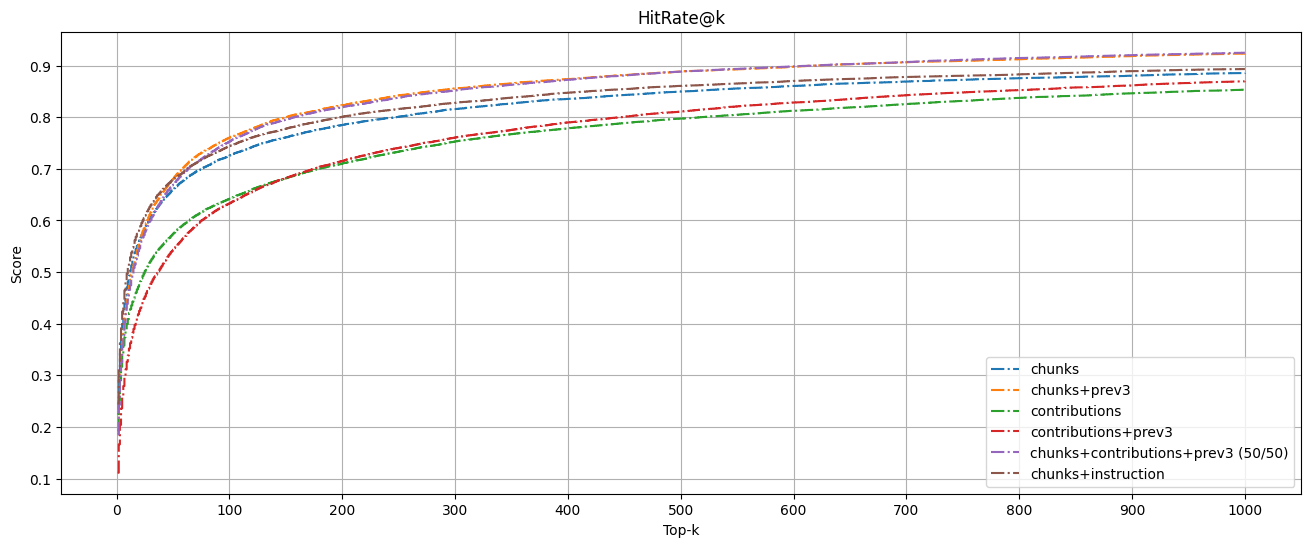

In [4]:
k_values = [k for k in range(1, 1001)]

# Make a plot of the average hit rates (y-axis) and IoU (Jaccard) vs. top-k (x-axis)
plt.figure(figsize=(16, 6))
for path, name in zip(paths, names):
    with open(path, "r") as f:
        data = json.load(f)
    plt.plot(k_values, data['average_hit_rates'], drawstyle='steps-post', linestyle="-.", label=name)
plt.xlabel("Top-k")
plt.ylabel("Score")
plt.title("HitRate@k")
plt.legend()
plt.grid()

# Set x-ticks every 100
plt.gca().xaxis.set_major_locator(MultipleLocator(100))

plt.show()


In [ ]:
plt.savefig(f"k1000.png")
plt.close()

In [ ]:
k_values = [k for k in range(1, 201)]

chunk_data = None
with open(paths[0], "r") as f:
    chunk_data = json.load(f)
contribution_data = None
with open(paths[1], "r") as f:
    contribution_data = json.load(f)

# Make a plot of the average hit rates (y-axis) and IoU (Jaccard) vs. top-k (x-axis)
plt.figure(figsize=(16, 8))
for path, name in zip(paths, names):
    with open(path, "r") as f:
        data = json.load(f)
    plt.plot(k_values, data["average_hit_rates"][:200], linestyle="-", label=name)
plt.xlabel("Top-k")
plt.ylabel("Score")
plt.title("HitRate@k")
plt.legend()
plt.grid()
plt.savefig(f"k200.png")
plt.close()